# Aplicação LSTM para Análise de Sentimentos

***

## Modelo 4 (Rede Neural com Embedding e LSTM - Long Short Term Memory): Classificação de Sentimentos sobre Companhias Aéreas

O Objetivo é criar um modelo que consiga aprender e predizer se determinado tweet indica um sentimento *bom*, *ruim* ou *neutro* em relação as companhias aereas em questão.

***

#### Diferenças de Aplicação

Diferentemente da aplicação ocorrida [neste](https://github.com/Andrercouto/NLP/blob/main/portugues/MLcomNLP/RedesNeuraisNLP.ipynb) notebook, a classificação de sentimentos não ocorrerá de forma binária (neste caso pela existência dos sentimentos *bom*, *ruim* e *neutro*). Em termos de implementação do modelo, há uma diferença na camada de saída, anteriormente definida da seguinte forma:

        -  model.add(Dense(units=1, activation='sigmoid'))

Para que as probabilidades de *evento* se mantivessem entre 0 e 1 (dado o formato da curva sigmoide).

Dessa forma, seria preciso de uma camada de saída que possibilitasse uma classificação multiclasse. Para isso, como camada de saída utilizaremos:

        -  model.add(Dense(units=3, activation='softmax'))

Também será necessário aplicar a técnica de *dummiezação*, transformando cada uma das três classes em uma coluna binária. 

#### LSTM (Long Short Term Memory)

Uma das possíveis técnicas para levarmmos em conta a *ordem* e o *contexto* das diferentes palavras é o uso de Redes Neurais Recorrentes. Um dos tipos de Rede Neural Recorrente é o LSTM, que possui mecanismos chamados *gates* que aprendem quais dados devem ser mantidos ou náo no processo de treinamento.

#### LSTM Bidirecional

A LSTM bidirecional, processa sequências em ambas as direções, permitindo que o modelo capture dependências contextuais anteriores e posteriores, melhorando sua capacidade de compreensão do texto.

#### Regularização L2

Para evitar overfitting, será aplicada a regularização L2 nas camadas densas do modelo. Essa técnica penaliza pesos excessivamente grandes, ajudando a generalizar melhor o modelo.

***
### Pipeline

A *pipeline* contará com os seguintes passos:

- Importação dos dados (e Análise Exploratória dos Dados);

- Tratamento dos Dados;

- Criação do modelo;

- Previsõese Avaliação de Performance.



### Importação dos Dados

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import CountVectorizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, SpatialDropout1D, Embedding, Bidirectional
from keras.metrics import AUC
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

sns.set()
warnings.filterwarnings("ignore")

In [23]:
# Obtendo os tweets
dados_tweets = pd.read_csv('tweets.csv')
dados_tweets.head(2)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
0,Tr_tweet_1,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2/24/2015 11:35,NaN,Eastern Time (US & Canada)
1,Tr_tweet_2,positive,0.3486,NaN,0.0,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2/24/2015 11:15,NaN,Pacific Time (US & Canada)


### Análise Exploratória

Qual o percentuais de ocorrência dos sentimentos?

In [3]:
# Verificando contagem
dados_tweets.airline_sentiment.value_counts()

airline_sentiment
negative    2134
neutral      679
positive     525
Name: count, dtype: int64

O campo '*airline_sentiment_confidence*' diz respeito à segurança em relação ao sentimento do registro, pode ser útil verificar a distribuição dessa variável.

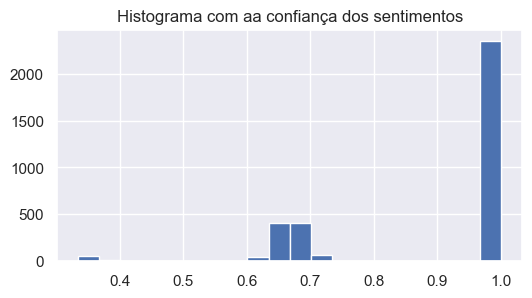

In [4]:
# Verificando a distribuição de confiança do sentimento
plt.figure(figsize=(6,3))
plt.title('Histograma com aa confiança dos sentimentos')
plt.hist(dados_tweets.airline_sentiment_confidence, bins=20)
plt.show()

A maior parte dos registros possuem 100% de certeza do sentimento. Apenas esses registros serão usados.

In [5]:
# Filtrando apenas os registros com 100% de confianca
dados_tweets = dados_tweets.loc[dados_tweets['airline_sentiment_confidence']==1]

In [6]:
# Verificando contagem
dados_tweets.airline_sentiment.value_counts()

airline_sentiment
negative    1698
positive     331
neutral      327
Name: count, dtype: int64

In [7]:
# Analisando sentimento por Companhia
df_airlines = dados_tweets.pivot_table(index='airline', columns='airline_sentiment', aggfunc='size')
df_airlines = df_airlines.div(df_airlines.sum(axis=1), axis=0)
df_airlines

airline_sentiment,negative,neutral,positive
airline,,,
United,0.765844,0.119981,0.114175
Virgin America,0.397924,0.273356,0.328720


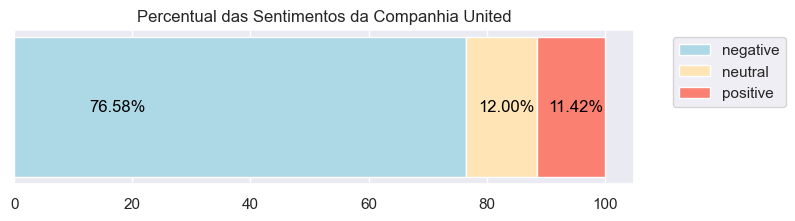

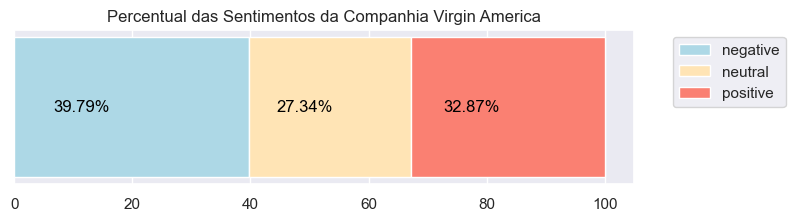

In [8]:
# Representação visual das classes
for airline in df_airlines.index:
    perc = df_airlines.loc[airline] * 100
    acumulado = 0
    
    # inicializando figura
    plt.figure(figsize=(8, 2))
    plt.yticks([])
    
    # Plotando a barras de sentimentos (ruim, mediano, bom)
    for i, v in enumerate(perc):
        plt.barh('Tweets', v, left=acumulado, color=['lightblue','moccasin', 'salmon'][i], height=0.5)
        acumulado += v  
    
    
    # Texto
    acumulado = 0
    for i, v in enumerate(perc):
        plt.text(acumulado + v/6 , 'Tweets', f'{v:.2f}%', va='center', color='black')
        acumulado += v 
    
    
    plt.legend(perc.index, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f'Percentual das Sentimentos da Companhia {airline}')
    plt.show()

Claramente a "United" possui mais reações negativas do que a "Virgin America".

### Tratamento dos Dados

In [9]:
# Tokenizando o corpus
token = Tokenizer(num_words=10000)
token.fit_on_texts(dados_tweets.text.values)

# Transformando os textos dos tweets
X = token.texts_to_sequences(dados_tweets.text.values)

# "Completando" tokens
X = pad_sequences(X, padding="post", maxlen=100)

In [10]:
print(X)

[[  18   61 2272 ...    0    0    0]
 [  18   79  121 ...    0    0    0]
 [  18    8   79 ...    0    0    0]
 ...
 [   1    6   19 ...    0    0    0]
 [   1  751   69 ...    0    0    0]
 [   1    5   52 ...    0    0    0]]


O Corpus está em um formato tabular.

Agora será necessário tratar a classe (campo '*airline_sentiment*') através de dummiezação.

In [11]:
# Obtendo dummies
y = pd.get_dummies(dados_tweets['airline_sentiment']).values

In [12]:
y[0:10]

array([[False,  True, False],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True]])

In [13]:
# Separacao treino/teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = .3)

### Criação do Modelo

In [14]:
# Obtendo as recorrências das classes no dataset de treino
y_treino_classes = np.argmax(y_treino, axis=1)  

# Calculando os pesos das classes (serão necessarios para o modelo)
class_weights = compute_class_weight('balanced', classes=np.unique(y_treino_classes), y=y_treino_classes)
class_weight_dict = dict(enumerate(class_weights))

In [15]:
# Iniciando o modelo
model = Sequential()

# Camada de Embedding (essencial para o trnasformar frases em vetores densos)
model.add(Embedding(len(token.word_index) + 1, 250, input_length=X.shape[1]))

# Dropout
model.add(SpatialDropout1D(0.2))

# Camada LSTM Bidirecional (processa sequências em ambas as direções, capturando contextos anteriores e posteriores)
model.add(Bidirectional(LSTM(150, dropout=0.2, recurrent_dropout=0.1)))

# Camadas Densas ( a regularização L2 serve para evitar overfitting)
model.add(Dense(150, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.02)))

# Camada de saída (configurações de um problema de classificação multiclasse)
model.add(Dense(y_treino.shape[1], activation='softmax'))

In [18]:
# Compilando o modelo (learning rate diferente inferior ao padráo)
model.compile(loss="categorical_crossentropy",
              optimizer=Adam(learning_rate=.001),
              metrics=[AUC(name="auc")])

# Estrutura do modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 250)            │       1,334,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 100, 250)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 300)                 │         481,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 150)                 │          45,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           7,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,868,553 (7.13 MB)

 Trainable params: 1,868,553 (7.13 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Definindo a parada adiantada (interrompe o treinamento se 'val_loss' não melhorar nas últimas 5 épocas, restaurando os melhores pesos)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Treinamento com pesos das classes
model.fit(X_treino,
          y_treino,
          epochs=50,
          batch_size=256,
          class_weight=class_weight_dict,
          validation_data=(X_teste, y_teste),
          callbacks=[early_stopping])

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 650ms/step - auc: 0.7101 - loss: 5.7142 - val_auc: 0.7540 - val_loss: 5.0454
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 547ms/step - auc: 0.7361 - loss: 4.9375 - val_auc: 0.8503 - val_loss: 4.2623
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 572ms/step - auc: 0.8377 - loss: 4.3079 - val_auc: 0.6996 - val_loss: 3.9335
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 627ms/step - auc: 0.8392 - loss: 3.6983 - val_auc: 0.8644 - val_loss: 3.2110
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 627ms/step - auc: 0.8997 - loss: 3.1503 - val_auc: 0.9042 - val_loss: 2.6851
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 647ms/step - auc: 0.9577 - loss: 2.6380 - val_auc: 0.8829 - val_loss: 2.4137
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 710ms/step - auc: 0.9515 - loss: 2.2039 - val_auc: 0.9159 - val_loss: 2.0677
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 742ms/step - auc: 0.9801 - loss: 1.8288 - val_auc: 0.8802 - val_loss: 1.9625
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 767ms/step - auc: 0.9798 - loss: 

### Previsões e Avaliação de Performance

In [20]:
# Previsoes do modelo
y_pred_prob = model.predict(X_teste)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step


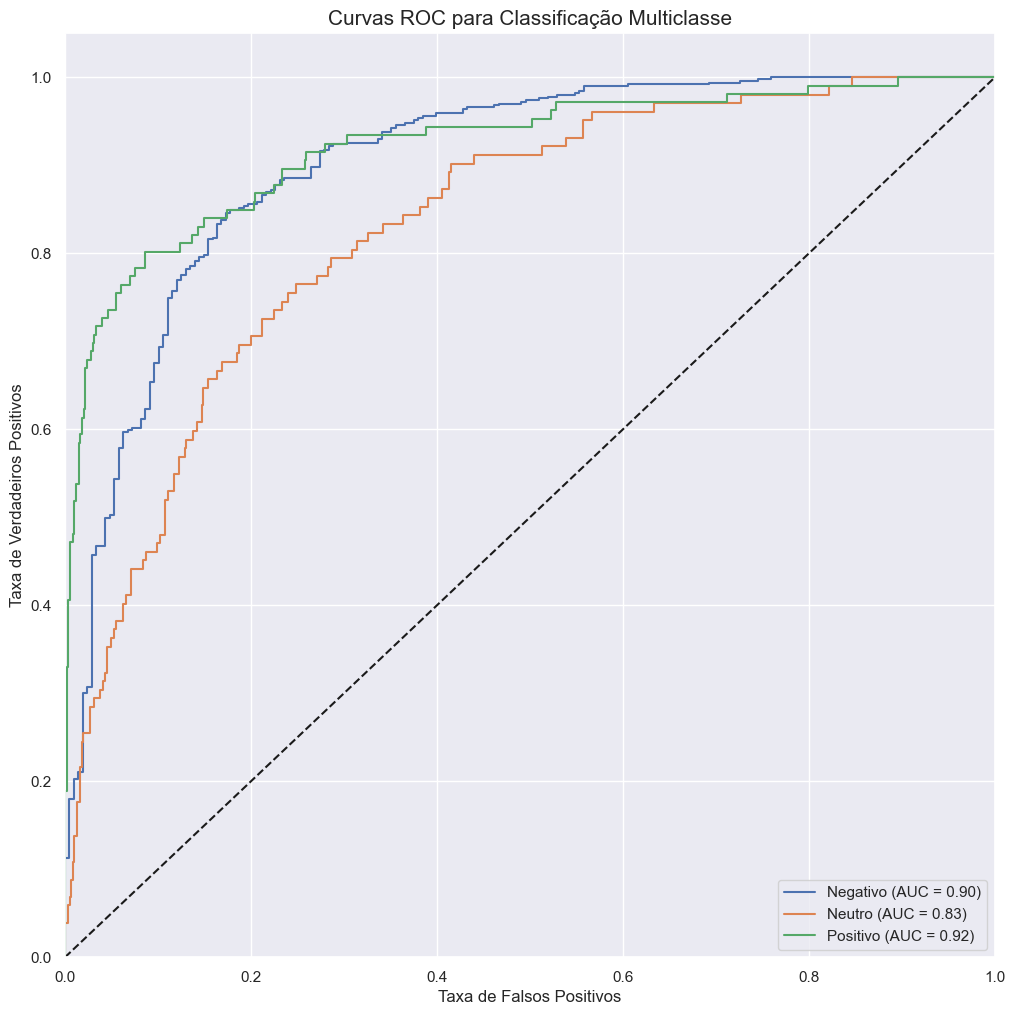

In [21]:
# Plotando as curvas ROC

y_true = y_teste  # classes verdadeiras 
y_scores = y_pred_prob  # probabilidades preditas pelo modelo
n_classes = y_treino.shape[1]

# Inicialize a figura
plt.figure(figsize=(12,12))

# Dicionário de classes
class_labels = {0: 'Negativo', 1: 'Neutro', 2: 'Positivo'}

# curva ROC de cada classe
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

# Configurações do gráfico
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curvas ROC para Classificação Multiclasse', size=15)
plt.legend(loc='lower right')
plt.show()

**Todos os valores de AUC são bastante altos, indicando o bom desempenho do modelo em distinguir entre as classes.** É válido destacar que o modelo apresenta um desempenho relativamente consistente entre as classes.